<a href="https://colab.research.google.com/github/tainangao/webscraping---real-estate/blob/master/CapeTown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
raw_data = pd.read_csv('rp.csv')
raw_data.head(2)

title  ...                                                url
0  2 bedroom flat/apartment for rent  ...  https://www.residentialpeople.com/za/property/...
1       3 bedroom townhouse for sale  ...  https://www.residentialpeople.com/za/property/...

[2 rows x 10 columns]

**Keep only properties for sale and drop unrelated columns**

In [0]:
# start using a new dataframe
df = raw_data[raw_data.offering=='buy'].drop(columns=['title', 'offering', 'url'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9651 entries, 1 to 9662
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          9620 non-null   object
 1   bedrooms       9651 non-null   object
 2   bathrooms      9651 non-null   object
 3   latitude       9651 non-null   object
 4   longitude      9651 non-null   object
 5   floor_size     9651 non-null   object
 6   property_type  9651 non-null   object
dtypes: object(7)
memory usage: 603.2+ KB


**Drop properties without price information**

In [0]:
df = df.dropna(axis=0, subset=['price'])
df.shape

(9620, 7)

**Clean null values**

In [0]:
df['floor_size' ] = df.floor_size.apply(lambda x: np.nan if 'S.O.A.' in x else x)

**Convert data types**

In [0]:
# start using a new dataframe

df1 = pd.DataFrame()

df1[['price', 'bedrooms', 'bathrooms', 'latitude', 'longitude']] = df[['price', 'bedrooms', 'bathrooms', 'latitude', 'longitude']].apply(pd.to_numeric)
df1['floor_size' ] = df.floor_size.apply(lambda x: x if x==np.nan else pd.to_numeric(x))
df1['property_type'] = df['property_type']

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9620 entries, 1 to 9662
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          9620 non-null   int64  
 1   bedrooms       9620 non-null   float64
 2   bathrooms      9620 non-null   int64  
 3   latitude       9620 non-null   float64
 4   longitude      9620 non-null   float64
 5   floor_size     2869 non-null   float64
 6   property_type  9620 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 601.2+ KB


In [0]:
df1.describe()

price     bedrooms  ...    longitude    floor_size
count  9.620000e+03  9620.000000  ...  9620.000000  2.869000e+03
mean   4.852213e+06     3.068867  ...    18.588949  4.853814e+03
std    7.763713e+06     1.506307  ...     0.179559  1.280334e+05
min    4.500000e+02     0.000000  ...    18.319033  1.000000e+00
25%    1.675000e+06     2.000000  ...    18.450288  9.500000e+01
50%    2.642450e+06     3.000000  ...    18.511764  2.000000e+02
75%    4.650000e+06     4.000000  ...    18.697742  4.060000e+02
max    1.725000e+08    32.000000  ...    19.294247  5.366131e+06

[8 rows x 6 columns]

**Eliminate Outliers**

In [0]:
# start using a new dataframe

Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

df2 = df1[~((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))).any(axis=1)]
df2.describe()

price     bedrooms  ...    longitude   floor_size
count  7.879000e+03  7879.000000  ...  7879.000000  2320.000000
mean   2.827188e+06     2.803084  ...    18.589662   214.890086
std    1.835357e+06     1.111814  ...     0.165117   169.981503
min    4.500000e+02     0.000000  ...    18.323419     1.000000
25%    1.550000e+06     2.000000  ...    18.465614    83.000000
50%    2.350000e+06     3.000000  ...    18.519284   160.000000
75%    3.530000e+06     3.000000  ...    18.694762   294.000000
max    9.100000e+06     7.000000  ...    19.044400   865.000000

[8 rows x 6 columns]

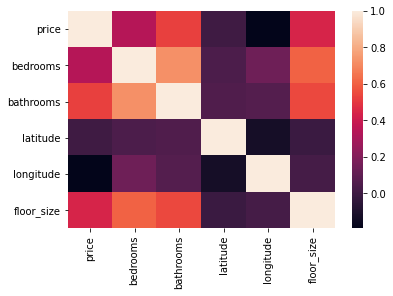

In [0]:
sns.heatmap(df2.corr())

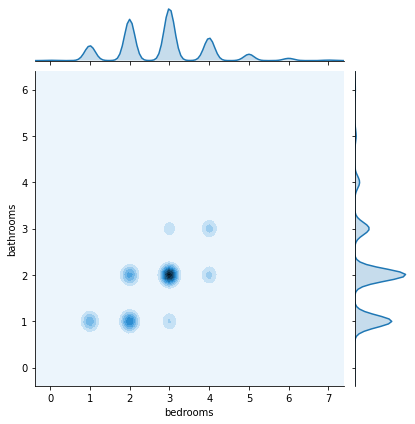

In [0]:
sns.jointplot(x='bedrooms',y='bathrooms',data=df2,kind='kde');

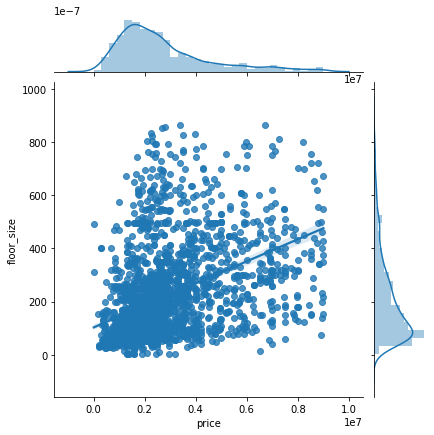

In [0]:
sns.jointplot(x='price',y='floor_size',data=df2,kind='reg');

**Get the geograpical coordinate of Cape Town**

In [0]:
from geopy.geocoders import Nominatim
import requests
import folium

address = 'Cape Town, South Africa'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cape Town is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cape Town is -33.928992, 18.417396.


**Create a new column: binned_price**

`binned_price` will be displayed with markers of various color in the Folium

In [0]:
ncluster = 50

bins = list(np.linspace(df2.price.min(), df2.price.max(), num=ncluster))
df2['binned_price'] = np.searchsorted(bins, df2['price'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(ncluster)
ys = [i + x + (i*x)**2 for i in range(ncluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# create map of Cape Town using latitude and longitude values
map_ct = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lng, price in zip(df2['latitude'], df2['longitude'], df2['binned_price']):
    # label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color=rainbow[int(price)-1],
        fill=True,
        fill_color=rainbow[int(price)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_ct)  
    
map_ct

In [0]:
# workcloud for descriptions
# neighborhoods 

In [0]:
'http://public-chesva.opendata.arcgis.com/datasets/e8a4bed38fdf403ca5479779884aadc2_3.geojson'

NameError: ignored